<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Lections/06L_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Автоэнкодеры. Сегментация изображений.

## Supervised vs Unsupervised learning

Всё это время мы находились в области т.н. Supervised learning, или "обучения с учителем". Мы явно сообщали модели, что именно ей надо предсказывать. В частности, показывали модели множество объектов, каждому из которых была сопоставлена метка, и учили разделять новые объекты на кучки.

Сегодня мы рассмотрим другой подход, имеющий отношение к Unsupervised learning, или обучению без учителя. В этом случае есть объекты, но их метки неизвестны. Модель должна просмотреть все изображения и научиться **неявно** группировать их по похожести.


<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/unsupervised2.png" alt="Drawing" width= "700px;"/>

В реальных задачах очень часто бывает мало размеченных данных, но при этом имеется огромное количество неразмеченных. Возможно, модели удастся выделить какие-то скрытые закономерности в данных и в итоге разделить их так, как мы хотим. Возможно, обучаясь таким образом, мы сможем извлечь из данных куда больше информации чем если мы будем обучаться в пределах какой-то конкретной supervised задачи.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/supervised_vs_unsupervised.png" alt="Drawing" width= "700px;"/>

## Representation learning

С Unsupervised learning очень тесно связано понятие **Representation learning**, или выучивание представления данных. Выученное представление может использоваться как источник признаков для обучения нейросети на целевую задачу, либо как источник признаков для других, не обязательно нейросевых, алгоритмов.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/foundation_model.png" alt="Drawing" width= "800px;"/>

Почему это важно?

Часто обучение без учителя дает результаты, которые в дальнейшем позволяют быстро адаптироваться к новым задачам обучения с учителем и переключаться между ними. На одном из прошлых занятий вы делали Transfer learning. И получилось гораздо лучше чем когда вы решали задачу с нуля. Это произошло потому, что гораздо лучше выучить хорошо генерализующую модель выделять хорошее представление, а потом заменить последние слои и дообучить их на конкретную задачу, чем с нуля учить модель под какую-то узкую задачу.

Куда лучше выучить одно хорошее представление кодирующих последовательностей и с помощью него решать кучу задач, нежели отдельно учиться на каждую задачу отдельно. Хотим иметь модель "швейцарский нож", которую все будут использовать для разных задач и много нас цитировать =)


## Снижение размерности

Ранее мы уже проходили различные алгоритмы снижения размерности. Помним, что часто можно преобразовать данные из пространства высокой размерности в некое пространство более низкой размерности, в котором сохранятся различные свойства объектов, например расстояние между ними. Также очень хотелось бы, чтобы из этого более низкоразмерного представления можно было восстанавливать исходные объекты с крайне малой ошибкой -- это позволило бы нам проводить все тяжелые и чувствительные операции на низкоразмерном пространстве получая экономию по времени и памяти и при этом применять алгоритмы, страдающие от проклятия размерности.

Крайне немаловажно (особенно в биологии) и то, что подобная процедура позволила бы избавиться от шума в данных.



Итак, мы предполагаем, что "истинная" размерность пространства признаков, кодирующих наши объекты, в большинстве случаев значительно ниже представления данных. Очень часто это действительно так.

<img src="https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/dim_reduction/img/manifold1.png" alt="Drawing" width= "700px;"/>
<img src="https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/dim_reduction/img/manifold2.png" alt="Drawing" width= "700px;"/>


Как же нам научиться выявлять для множества объектов такие скрытые пространства признаков?

Вспоминаем, например, метод главных компонент (PCA). Это метод отображения векторов свойств объектов (помним, что у нас объект всегда описывается вектором свойств, длина вектора — это количество свойств) в вектора производных свойств (компонент), меньшей длины с помощью линейной комбинации, чтобы обратной операцией можно было восстановить значения векторов свойств как можно ближе к исходным. То есть PCA выполняет сжатие информации, и он работает для группы объектов.

Успех?

Обычно PCA работает для центрированных переменных. Каждая следующая компонента проводится перпендикулярно предыдущим и так, чтобы объяснить наибольшую часть разницы, не объясненной предыдущими компонентами между объектами.
PCA выполняет линейную комбинацию над компонентами исходного вектора свойств объекта, но это не всегда хорошо. PCA видит **только линейные зависимости**, а хотелось бы не только их. Кроме того, нам крайне желательно бы не просто разделять объекты на кучки, но и не оставлять между ними "пустых пространств" (проводить гладкую интерполяцию, об этом -- чуть позже).


## Автоэнкодеры

Autoencoder — архитектура нейросети, которая сначала с помощью нейросети-энкодера сжимает изображение в вектор небольшой размерности (скрытое представление), а затем восстанавливает этот вектор в исходную картинку с помощью нейросети-декодера.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/encoder_decoder.png" alt="Drawing" width= "500px;"/>


Практика показывает, что скрытое представление картинки позволяет делать очень интересные и красивые вещи — например, очищать изображение от шума, проводить гладкую интерполяцию между 2 написанными от руки цифрами, генерировать новую рукописную цифру со стилем от имеющейся.

Откуда берутся эти свойства? Они являются следствием сжатия информации. Когда мы правильным образом пропускаем наше изображение через сеть, а затем восстанавливаем его, то сеть запоминает преимущественно важные детали картинки, т.к. именно они вносят наибольший вклад в функцию потерь. Наличие шума также вносит вклад в функцию потерь, но гораздо меньший.

Поэтому мы надеемся, что такое реобразование нашей нейросетью поможет нам убрать часть шума из изображения или других данных. Если не так сильно ограничивать информацию в точке максимального сжатия, становится возможно сохранить большее количество деталей.



PCA можно считать "частным случаем" AE, если в нём сделать только один плотный слой (Dense) с количеством нейронов, равным требуемому числу компонент, сделать линейную функцию активации, и требовать восстановление объекта наиболее близко к поданному на вход. Кроме этого, необходимо будет нормировать признаки перед подачей их на вход AE.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/pca_as_autoencoder.png" alt="Drawing" width= "500px;"/>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_style("whitegrid")

from sklearn.decomposition import PCA
from itertools import chain

USE_CUDA = True

In [ ]:
root = "./data"

train_set = dset.MNIST(
    root=root, train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_set = dset.MNIST(
    root=root, train=False, transform=torchvision.transforms.ToTensor(), download=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2874910.13it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 333216.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3194275.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11332854.71it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
x_train = train_set.data.numpy()
y_train = train_set.targets.numpy()
x_test = test_set.data.numpy()
y_test = test_set.targets.numpy()

x_train, x_test = x_train / 255.0, x_test / 255.0
xt_shape = x_train.shape
print("Initial shape ", xt_shape)
xt_flat = x_train.reshape(-1, xt_shape[1] * xt_shape[2])
print("Reshaped to ", xt_flat.shape)

Initial shape  (60000, 28, 28)
Reshaped to  (60000, 784)


При помощи PCA попробуем получить латентное представление, сохраняющее не менее 90% исходной дисперсии данных. Посмотрим, какой же будет размерность такого представления.

In [ ]:
pca = PCA(0.90)
xt_encoded = pca.fit_transform(xt_flat)
print("Initial features: ", xt_flat.shape[1])
print("Encoded features: ", pca.n_components_)

Initial features:  784
Encoded features:  87


Энкодер (он же декодер, ведь это просто обратная матрица от энкодера PCA) обучен. Теперь можно проверить, как он закодирует и раскодирует тестовую выборку. Для этого проведём такие же преобразования размерности для неё.

In [ ]:
xtest_shape = x_test.shape
print("Encoded xtest_decoded shape is ", x_test.shape)
xtest_flat = x_test.reshape(-1, xtest_shape[1] * xtest_shape[2])
xtest_encoded = pca.transform(xtest_flat)
xtest_decoded = pca.inverse_transform(xtest_encoded).reshape(xtest_shape)
print("Decoded xtest_decoded shape is ", xtest_decoded.shape)

Encoded xtest_decoded shape is  (10000, 28, 28)
Decoded xtest_decoded shape is  (10000, 28, 28)


Теперь нужно определить функцию для отрисовки изображений MNIST. Она будет выводить несколько изображений в ряд, поэтому будет принимать трёхмерный массив. Шкала не должна быть автоподстраиваемой, так как после обработки изображения выйдут за диапазон (0,1), в котором заданы исходные изображения. Мы зафиксируем шкалу в диапазоне (0,1).

In [ ]:
def plot_images(images, title):
    fig = plt.figure(figsize=(16, 3))
    columns = images.shape[0]
    rows = 1
    for i in range(columns):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(images[i], cmap="gray_r", clim=(0, 1))
    fig.suptitle(title)
    plt.show()

Выведем исходное и закодированное изображение для некоторых изображений, которые мы случайным образом выберем из всей тестовой выборки.

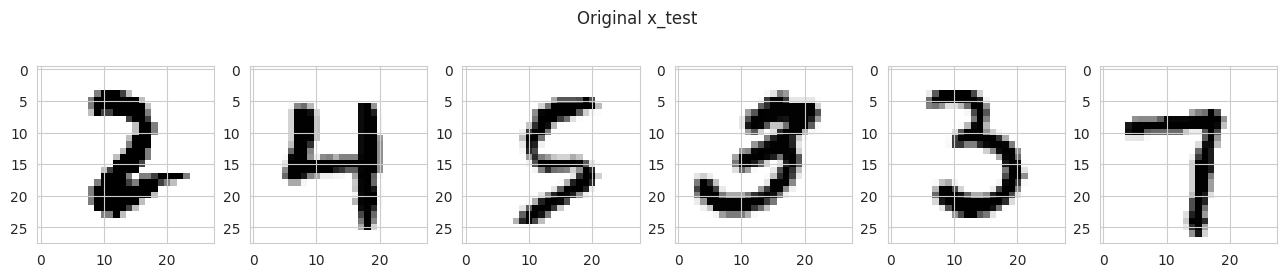

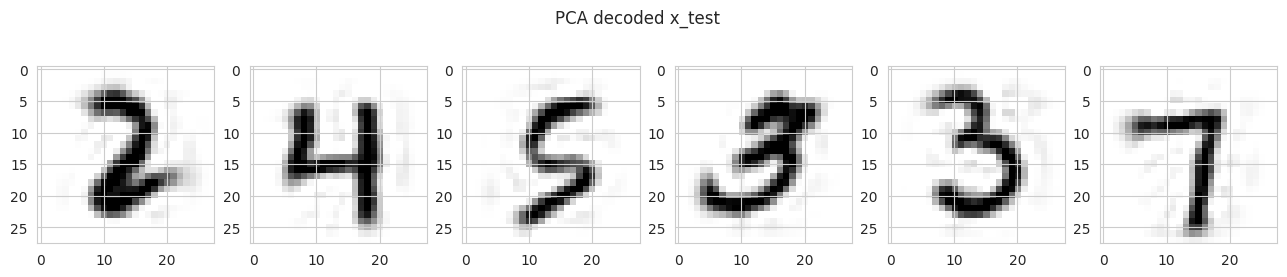

In [ ]:
sample_indices = np.random.choice(x_test.shape[0], 6)
samples_orig = x_test[sample_indices]
samples_decoded = xtest_decoded[sample_indices]
plot_images(samples_orig, "Original x_test")
plot_images(samples_decoded, "PCA decoded x_test")

Видно, что `pca.n_components_` (87 для 90% PCA) достаточно для описания картинок MNIST вместо 784 исходных пикселей. Но при этом нужно хранить матрицу кодирования-декодирования, а также изображения получаются немного зашумлёнными.

Степень сжатия у нас условно 87/784 ~= 0.11. То есть сжатие в 9 раз. «Условно», так как мы не учитываем конверсию типов: сжатое изображение хранится во `float`, а исходное в `uint8`, который требует в 4 раза меньше байт.

Теперь посмотрим, как наш "автоэнкодер без нейросетей" справится с очисткой от зашумления. Для этого сделаем функцию добавления шумов к объектам и посмотрим результат.

In [ ]:
def mnist_add_noise(noise_factor, dataset):
    return dataset + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=dataset.shape
    )

def PCArecode(dataset):
    dataset_flat = dataset.reshape(-1, dataset.shape[1] * dataset.shape[2])
    return pca.inverse_transform(pca.transform(dataset_flat)).reshape(dataset.shape)

In [ ]:
x_test_noisy = mnist_add_noise(0.3, x_test)
samples_noisy = x_test_noisy[sample_indices]

x_filtered = PCArecode(x_test_noisy)
samples_filtered = x_filtered[sample_indices]

Для простоты сравнения напишем функцию, которая будет строить зашумленные и восстановленные образцы друг под другом.

In [ ]:
def plot_digits(*args, invert_colors=True, digit_size=28, name=None):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    if invert_colors:
        figure = 1 - figure

    plt.figure(figsize=(2 * n, 2 * len(args)))

    plt.imshow(figure, cmap="Greys_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()

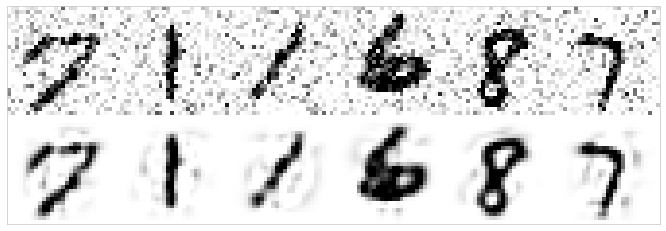

In [ ]:
plot_digits(samples_noisy, samples_filtered)

Итак, шумы стали значительно меньше, но и артефакты вокруг цифры усилились. Это неудивительно, ведь мы сжимали информацию линейным образом с 784 признаков на целых 87 компоненты. В результате находимся где-то на промежуточном этапе, где и сжатие добавило артефактов, и особо значимые признаки до сих пор размыты.

### Латентное представление для цифр после PCA

Посмотрим теперь на то, как делятся наши картинки в латентном представлении.

In [ ]:
def pca_latent(dataset):
    dataset_flat = dataset.reshape(-1, dataset.shape[1] * dataset.shape[2])
    return pca.transform(dataset_flat)

In [ ]:
def plot_manifold(latent_r, labels=None, alpha=0.5):
    plt.figure(figsize=(10, 10))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], cmap="tab10", alpha=0.9)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=0.9)
        plt.colorbar()
    plt.show()

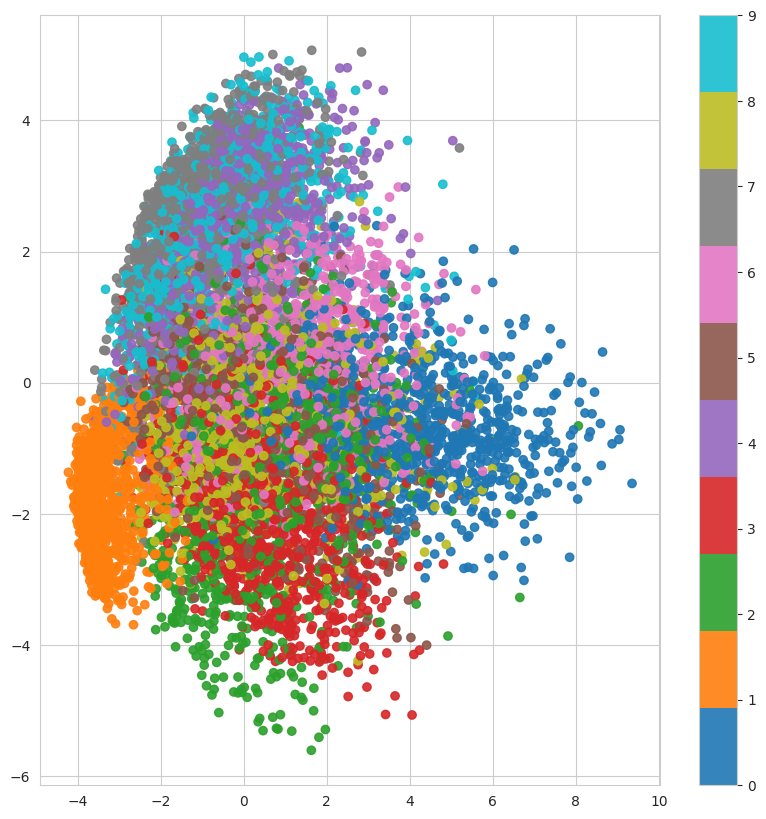

In [ ]:
latent_r = pca_latent(x_test)
plot_manifold(latent_r, y_test)

Видим, что латентное представление слабо разделяет картинки по тому, какие цифры на них изображены. Только 1 расположены более-менее обособленно.

## Реализация автоэнкодера

Итак, вспомним, что в автоэнкодере одна сеть переводит пространство свойств в пространство меньшей размерности, а другая сеть восстанавливает исходное изображение. Вместо прямого вычисления коэффициентов сети (как делает PCA) мы будем её обучать. Для обучения нужно определить функцию потерь. Мы возьмём среднеквадратичное расстояние (MSE). То есть потребуем, чтобы значения пикселей исходного изображения и восстановленного отличались несильно.

$$\mathcal{L}(x, \hat{x}) = \dfrac{1}{N} \sum_{i=1}^{N} ||x_{i} - \hat{x}_{i}||^{2}$$


Для задачи простого сжатия-восстановления объектов MNIST нам [достаточно](https://afagarap.github.io/2020/01/26/implementing-autoencoder-in-pytorch.html) очень простой архитектуры из 4 полносвязных слоев:

```
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
```

Мы можем использовать разные варианты архитектур для энкодера и декодера: на плотных слоя или на свёрточных. С обычными сверточными слоями мы уже знакомы, а вот сверточные слои, повышающие размерность изображения, встретились нам впервые. Подробнее мы о них погооврим ближе к концу занятия.


Сразу напишем достаточно мощные модели на сверточных слоях. В конце кодировщика будем выдавать вектор размера `latent_size`. И декодировщик должен принимать этот вектор и восстанавливать до целого изображения.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        modules = []
        in_channels = 1
        for h_dim in hidden_dims[:-1]:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(),
            )
        )
        modules.append(nn.Flatten())
        modules.append(nn.Linear(hidden_dims[-1] * 4, latent_size))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32]
        self.linear = nn.Linear(in_features=latent_size, out_features=hidden_dims[0])

        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    hidden_dims[-1],
                    hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 512, 1, 1)
        x = self.decoder(x)
        return x

Напишем основную функцию для обучения нейросети. Сделаем ее модульной: вспомогательные функции `single_pass_handler` и `loss_handler` будут меняться на протяжении лекции в зависимости от модели, которую мы обучаем.

In [ ]:
def train(
    enc,
    dec,
    loader,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
    log_interval=500,
):
    for batch_idx, (data, lab) in enumerate(loader):
        batch_size = data.size(0)
        optimizer.zero_grad()
        if USE_CUDA:
            data = data.cuda()
            lab = lab.cuda()

        latent, output = single_pass_handler(encoder, decoder, data, lab)

        loss = loss_handler(data, output, latent)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                    loss.item(),
                )
            )


def ae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    recons = decoder(latent)
    return latent, recons


def ae_loss_handler(data, recons, *args, **kwargs):
    return F.binary_cross_entropy(recons, data)

In [ ]:
# загрузим данные
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False
)

In [ ]:
# Определим модель
latent_size = 2
learning_rate = 1e-4
encoder = Encoder(latent_size=latent_size)
decoder = Decoder(latent_size=latent_size)

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

# Обратите внимание: оптимизатору можем передать сразу параметры от нескольких моделей
optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)

In [ ]:
for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=ae_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.728195
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.235511
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.224410
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.218165
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.208797
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.206803
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.200254
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.182561
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.193826
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.200761
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.188360
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.201035
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.208903
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.182330
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.184219
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.181108
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.192854
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.176228
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.176640
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.181675
Train Epoch:

Напишем функцию, позволяющую удобно прогонять датасет через обученную нейросеть

In [ ]:
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recontr=True,
    return_latent=True,
    return_labels=True,
):

    if return_real:
        real = []
    if return_recontr:
        reconstr = []
    if return_latent:
        latent = []
    if return_labels:
        labels = []
    with torch.no_grad():
        for batch_idx, (data, lab) in enumerate(loader):
            if return_labels:
                labels.append(lab.numpy())
            if return_real:
                real.append(data.numpy())
            if USE_CUDA:
                data = data.cuda()
                lab = lab.cuda()
            rep, rec = single_pass_handler(encoder, decoder, data, lab)
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recontr:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recontr:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    if return_labels:
        labels = np.concatenate(labels)
        result["labels"] = labels
    return result

Сначала оценим то, насколько адекватно работает наш автоэнкодер в целом

In [ ]:
encoder = encoder.eval()
decoder = decoder.eval()

run_res = run_eval(encoder, decoder, test_loader, ae_pass_handler)

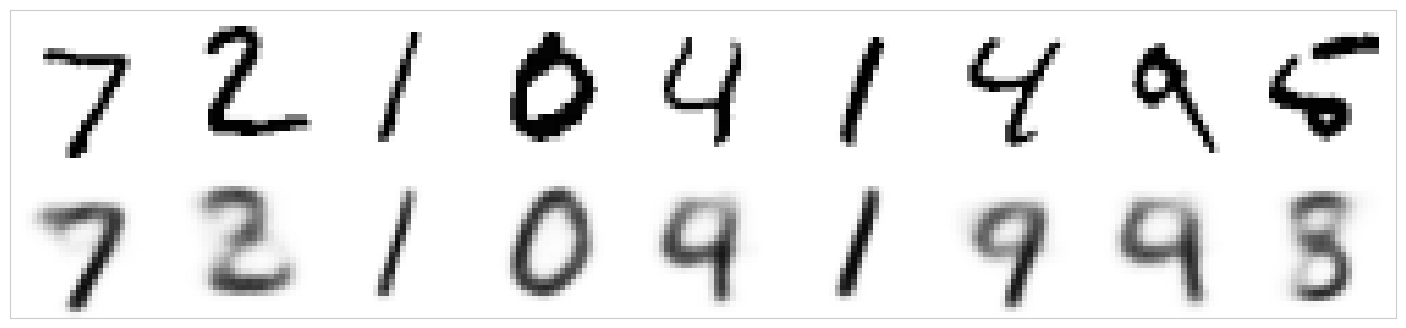

In [ ]:
plot_digits(run_res['real'][0:9], run_res['reconstr'][0:9])

И посмотрим, какое латетное представление он выучил.

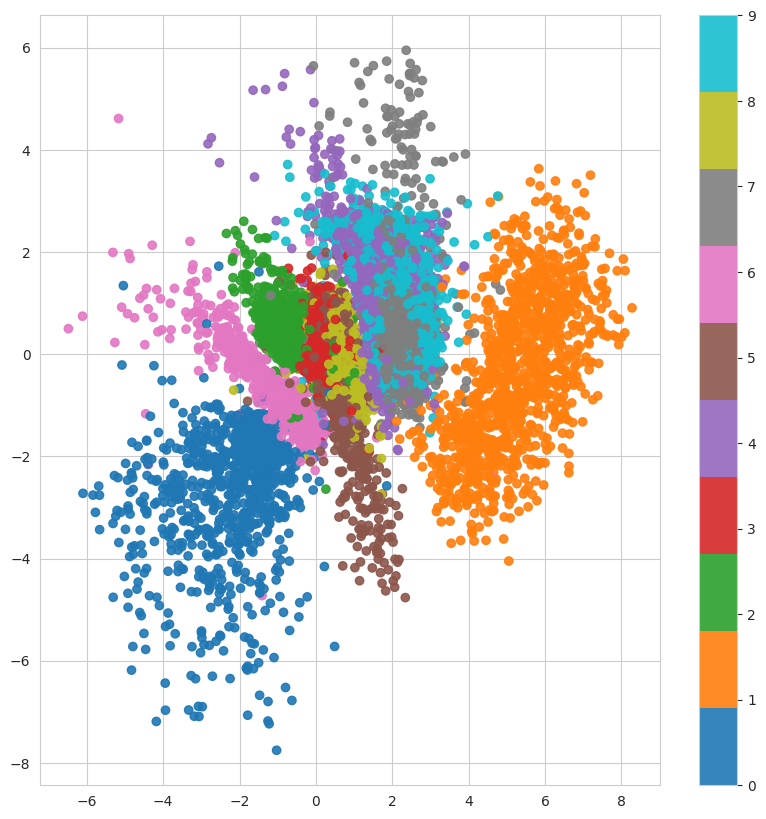

In [ ]:
plot_manifold(run_res['latent'], run_res['labels'])

Теперь увеличим размер латентного слоя до 24, переобучим автоэнкодер и посмотрим, насколько эффективно он будет бороться с шумом.

In [ ]:
latent_size = 24
learning_rate = 1e-4
encoder = Encoder(latent_size=latent_size)
decoder = Decoder(latent_size=latent_size)

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)

for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=ae_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.651505
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.206240
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.157139
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.132723
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.112320
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.109587
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.097974
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.097254
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.097444
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.092944
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.091992
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.086465
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.092603
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.094049
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.094621
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.094443
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.089210
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.091747
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.089975
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.086667
Train Epoch:

Сделаем dataloader, который добавляет в наш датасет шум автоматически

In [ ]:
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )

In [ ]:
test_noise_set = dset.MNIST(
    root=root,
    train=False,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), AddGaussianNoise(0.0, 0.30)]
    ),
    download=True,
)

test_noised_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_noise_set, list(range(64))),
    batch_size=batch_size,
    shuffle=False,
)

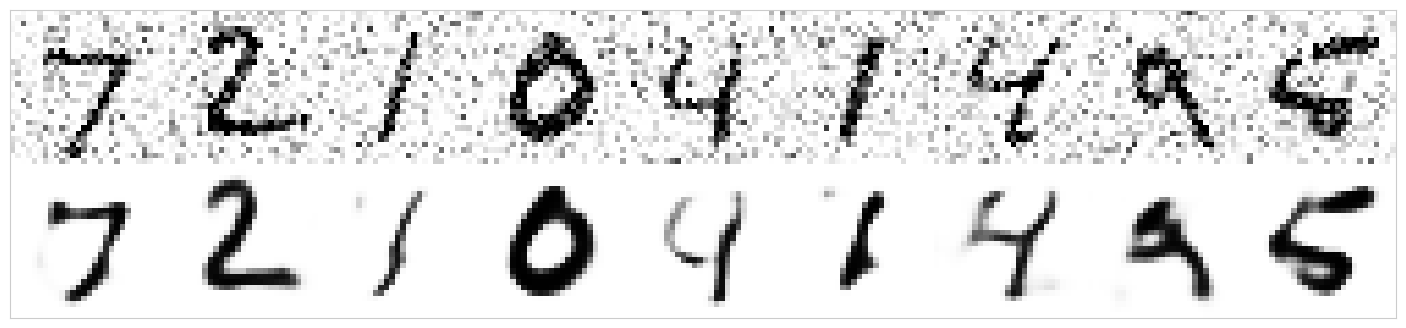

In [ ]:
run_res = run_eval(encoder, decoder, test_noised_dataloader, ae_pass_handler)

plot_digits(run_res['real'][0:9], run_res['reconstr'][0:9])

Качество сжатия мы оценили визуально выше. Если обратить внимание, то исходные картинки даже почистились от мелких шумов и странностей изображения и больше стали похожи на непрерывные линии. Размерность латентного пространства latent_size значительно меньше исходного количества свойств (784), поэтому мы получили неплохое сжатие изображения.

## Автоэнкодер как генератор и его ограничения. Плавная интерполяция

Точность восстановления -- не единственный показатель качества выученного латентного пространства. Во время работы наша модель может встетиться с разными объектами, в том числе не похожими на те, что были в обучающем датасете, а также с теми, что имеют признаки, позволяющие их отнести сразу к нескольким близким классам. Мы можем оценить адекватность поведения модели, подавая на вход декодеру некий случайный вектор размерности латентного пространства и получая новые объекты

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/generation_ae.png" alt="Drawing" width= "800px;"/>

Какое значение вектора выбрать? Мы же никак не управляли латентным пространством. Непонятно какие числа подставлять. Поэтому мы можем выбрать промежуточные значения между двумя представлением двух исходных изображений в латентном пространстве и получить плавную интерполяцию между изображениями. Постепенно свойства одного изображения будут исчезать, а появляться свойства другого.

Сначала обучим обычный автоэнкодер

In [ ]:
latent_size = 24
learning_rate = 1e-4
encoder = Encoder(latent_size=latent_size)
decoder = Decoder(latent_size=latent_size)

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()),
    lr=learning_rate,
    weight_decay=1e-5,
)
for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=ae_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.706778
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.221992
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.178404
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.138933
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.118186
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.111536
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.106946
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.102024
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.097201
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.107110
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.095177
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.096671
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.092079
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.091623
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.093168
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.086855
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.087108
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.086096
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.094764
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.089887
Train Epoch:

In [ ]:
# Возьмем несколько изображений

encoder = encoder.eval()
decoder = decoder.eval()

images, labels = next(iter(test_loader))

latent_space1 = encoder(images[labels==7][0:1].cuda())
latent_space2 = encoder(images[labels==6][0:1].cuda())

In [ ]:
interp_steps = 10
weight = torch.linspace(0, 1, steps=interp_steps)
interp = torch.lerp( # Does a linear interpolation of two tensors
    latent_space1.repeat(interp_steps, 1),
    latent_space2.repeat(interp_steps, 1),
    weight=weight.view(-1, 1).cuda(),
)
iterp_images = decoder(interp)

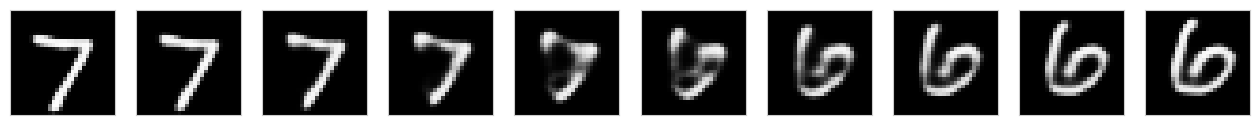

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=interp_steps, figsize=(16, 4))
for label in range(0, interp_steps):
    figure = iterp_images[label].cpu().detach().numpy()
    figure = figure.reshape(28, 28)
    ax = axs[label]
    ax.imshow(figure, cmap="Greys_r", clim=(0, 1))
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Так себе интерполяция вышла. Старое изображение затухает, а новое изображение появляется. Хочется, чтобы в промежуточных кадрах не было каких-то непонятных очертаний, а изображение было чем-то промежуточным по смыслу между стартовым и конечным изображением. Причина неудачи в том, что в латентном пространстве действительно возникли зоны, которые умеют декодироваться в хорошие изображения. Но никто не сказал, что между этими зонами должно быть что-то адекватное (что мы видели из представления).

Представим это графически. Пусть наш очень умный, содержащий очень много коэффициентов, энкодер и декодер смог разложить все входные объекты на одной оси (размерность латентного пространства — 1). По сути он каждому входному изображению присвоил номер и по номеру может это изображение вспомнить. То есть автоэнкодер очень переобученный. Тогда если мы возьмём промежуточный номер (пытаемся интерполировать), то какое изображение мы собираемся получить?

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/bad_latent_for_ae.png" alt="Drawing" width= "900px;"/>

Если мы хотим, чтобы декодированные промежуточные латентные состояния имели черты близких к ним объектов, то надо притянуть латентные координаты похожих объектов. Например вот так:

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/good_latent_for_ae.png" alt="Drawing" width= "900px;"/>

## Проблемы латентного пространства

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/from_bad_ae_to_vae.png" alt="Drawing" width= "900px;"/>


Мы имеем ситуацию, как на картинке слева. Переход-интерполяция между объектами проходит через зону отсутствующих в обучении объектов, декодирование которых даст несуществующие в реальности объекты. Нам не удастся погенерировать новые картинки, преобразовывая случайную точку из латентного пространства в случайную картинку.

Можем попробовать заставить наши объекты «лежать» рядом — будем штрафовать латентные представления, которые далеко уходят от начала координат.

Можем использовать как L1, так и L2 регуляризацию, так и их комбинацию — elastic loss.

Однако, это приведет просто к масштабированию распределения. Пробелы между выученными областями никуда не денутся, просто всё распределение схлопнется ближе к нулю, уменьшив расстояния между всеми объектами (и потенциально только добавит нам проблем). Нам надо одновременно получить связное латентное представление — чтобы у нас не возникало зон в латентном представлении, которым не соответствует ничего, но при этом объекты разных классов будут отделены друг от друга.



## Вероятностный автоэнкодер

При этом постановка задачи с автоэнкодером говорит нам, что есть некое пространство меньшей размерности $Z$, которое и обуславливает процесс генерации объектов из $X$. Все остальные различия — следствия случайности — один и тот же человек может по-разному нарисовать цифру 5.

Будем искать латентное пространство Z, которое удовлетворяет следующему условию:

$$p(x) = \int p(x, z)dz $$

Это искомое скрытое пространство по построению является непрерывным и описывает распределение областей в Z, из которых мы можем сгенерировать наши объекты X. Мы можем существенно сузить область поиска, ведь каждому $x$ из пространства $X$ соответствует лишь небольшая возможная область в $Z$.

Для этого будем также учить отображение из пространства $X$ в пространство $Z$, т.е, пытаться подобрать функцию $p(z|x)$. Также нам надо сохранить восстановление, так что одновременно будем учить отображение из пространства $Z$ в пространство $X$. Назовем функцию, которой будем его приближать $q(x|z)$.

Что же в случае автоэнкодера выполняет роль $p(z|x)$ и $q(x|z)$?
Очевидно — кодировщик и декодировщик соответственно.


Чтобы все получилось, нужно сделать с кодировщиком две вещи. Заметьте, что декодировщик мы оставим без изменений.

### Первая модификация

Пусть наш кодировщик генерирует на основе объекта X вектор средних и вектор стандартных отклонений.

Этих двух векторов хватает нам для того, чтобы задать многомерное нормальное распределение с независимыми компонентами (чтобы матрица ковариаций была диагональной), соответствующее данному объекту.

Чтобы получить латентное представление объекта, отличающегося от X только в силу случайности нам достаточно сгенерировать вектор из нормального распределения с такими параметрами.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/z_space.png" alt="Drawing" width= "900px;"/>


Далее мы можем требовать, чтобы из полученного латентного представления декодировщик восстанавливал объект, похожий на исходный.

Здесь, однако, сразу возникает возникает проблема с тем, что граф вычислений не может пропускать градиент через генератор случайного нормального числа. Если считать из определения, то даже малейшему изменению параметра могут соответствовать бесконечные изменения генерируемого числа (нормальное распределение определено на бесконечности). В общем, проблема.

Но мы можем вспомнить замечательное свойство одномерного нормального распределения:

$$N(\mu,\sigma^2) = N(0,1) * \sigma + \mu$$


Выполняется это и для многомерного случая. Потому сделаем следующее — будем генерировать значение из нормального распределения с средними 0 и дисперсиями 1, а затем домножать это на вектор стандартных отклонений и прибавлять вектор средних. Получится вот такое преобразование, которое называется **reparametrization trick**.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/vae-gaussian.png" alt="Drawing" width= "700px;"/>


Но если просто применить такой принцип, то мы получим другую проблему: модель всегда ищет способ упростить свою задачу. Значительно проще предсказывать не пару чисел а одно: среднее, а стандартные отклонения просто занулить. Тогда вместо желаемых распределений для каждого объекта она как и прежде будет опоставлять одну точку в латентном представлении.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/shrinking_distr.png" alt="Drawing" width= "800px;"/>

### Вторая модификация

Поэтому нам надо ввести регуляризацию, требующую от каждого распределения быть близким к нормальному распределению вокруг нуля координат латентного пространства с дисперсией 1 (штрафовать модель за "плохие" распределения).

В принципе, нам подойдёт любая адекватная мера расстояния между двумя распределениями. Для этого нам хорошо подойдет **Дивергенция Кульбака-Лейблера**, или KL-дивергенция.

### Дивергенция Кульбака-Лейблера


Дивергенция Кульбака-Лейблера -- мера удалённости друг от друга двух вероятностных распределений, которая считается по формуле:

$$KL(P||Q) = \int_X p(x)\log \dfrac {p(x)} {q(x)} dx$$

В теории информации p считается целевым распределением, а q — тем, с которым мы его сравниваем.
Важно понимать, что при этом KL не является мерой расстояния, а именно в общем случае $KL(P||Q) \ne KL(Q||P)$


[Оказывается](https://math.stackexchange.com/questions/90537/what-is-the-motivation-of-the-kullback-leibler-divergence), в подобных задачах она как правило обеспечивают бОльшую сходимость к требуемому распределениею, нежели та же L1-регуляризация.


Фактически мы сравниваем два бернулиевских распределения — то, которое хотим мы, с параметром p, и то, которое мы наблюдаем — с оценным параметром $\hat{p}$.

$$KL(P||Q) =  p(x) \log \dfrac {p(x)} {\hat{p}(x)} + (1 - p(x)) \log \dfrac {(1 - p(x))} {1 - \hat{p}(x)} $$

Далее лишь остается просуммировать данный лосс по батчу.


Чем KL-лосс лучше L1 и L2 лоссов? Он позволяет нам приближаться к решению более плавно.

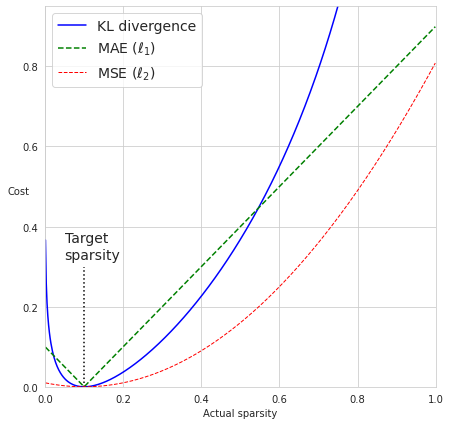

In [ ]:
plt.figure(figsize=(7, 7))
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.show()

### Совмещаем ошибку восстановления и KL-дивергению


Мы должны сохранить исходный лосс — декодировщик штрафуется за то, что не может нормально реконструировать объект -- и добавить к нему штраф за генерацию плохих распределений.

Формально это записывается следующим образом:

$$ vae\_loss = E_{z \sim Q(z|x)}[logP(x|z)] + KL[Q(z|x)||P(z)]$$

А в итоге:

$$ vae\_loss = ||x - \tilde{x}||^2 - \frac 1 2 (1 + \log\sigma^2 - \mu^2 - \sigma^2)$$



Первая компонента — это красиво записанное требование корректно восстанавливать объекты из обучающей выборки и чтобы при этом объекты, полученные их небольшим изменением за счет случайности также восстанавливались в объекты, близкие к объектам из тренировочной выборки. И удовлетворять этой компоненте лосса мы можем за счет того же лосса, который использовали в обычном автоэнкодере.
Вторая --  KL-loss.



Учет обеих компонент позволяет нам получить то, что мы хотели — непрерывное простанство, где нет «дыр» в представлении, и при этом близкие по смыслу объекты расположены рядом, а далекие — далеко.

In [ ]:
class VAEEncoder(Encoder):
    def __init__(self, latent_size):
        if latent_size % 2 != 0:
            raise Exception("Latent size for VAEEncoder must be even")
        super().__init__(latent_size)


def vae_split(latent):
    size = latent.shape[1] // 2
    mu = latent[:, :size]
    log_var = latent[:, size:]
    return mu, log_var


def vae_reparametrize(mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    z = torch.randn(mu.shape[0], mu.shape[1]).cuda()
    return z * sigma + mu


def vae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    mu, log_var = vae_split(latent)
    sample = vae_reparametrize(mu, log_var)
    recons = decoder(sample)
    return latent, recons


def kld_loss(mu, log_var):
    var = log_var.exp()
    kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - var, dim=1), dim=0)
    return kl_loss


def kl_loss_handler(data, recons, latent, kld_weight=0.1, *args, **kwargs):
    mu, log_var = vae_split(latent)
    kl_loss = kld_loss(mu, log_var)
    return kld_weight * kl_loss

In [ ]:
def vae_loss_handler(data, recons, latent, kld_weight=0.005, *args, **kwargs):
    mu, log_var = vae_split(latent)
    kl_loss = kld_loss(mu, log_var)
    return kld_weight * kl_loss + F.binary_cross_entropy(recons, data)

In [ ]:
latent_size = 2

learning_rate = 1e-4
encoder = VAEEncoder(latent_size=latent_size * 2)
decoder = Decoder(latent_size=latent_size)


encoder = encoder.cuda()
decoder = decoder.cuda()

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=vae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=450,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.761608
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.230635
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.231824
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.213367
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.203874
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.221439
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.215640
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.216540
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.218868
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.212896
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.214578
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.220426
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.199573
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.220504
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.221276


In [ ]:
encoder = encoder.eval()
decoder = decoder.eval()

run_res = run_eval(encoder, decoder, test_loader, vae_pass_handler)

mu, log_var = vae_split(run_res['latent'])

<Figure size 720x720 with 0 Axes>

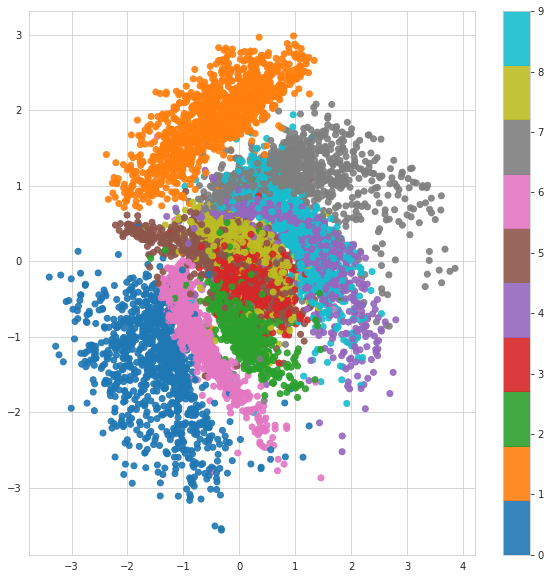

In [ ]:
plt.figure(figsize=(10, 10))
pal = sns.color_palette('Paired', n_colors=10)
plot_manifold(mu, run_res['labels'])

Видим, что цифры разделились в пространстве, но при этом жмутся друг к другу. При этом, что интересно, 4 и 9 почти неотличимы. Это можно объяснить тем, что двух компонент недостаточно, чтобы разделить настолько похожие цифры (по сути, все отличие в заполненности области между двумя рожками 4)

Посмотрим, как теперь получится интерполировать между 7 и 6. Для большей красоты и сравнимости с обычным автоэнкодером возьмем latent space такого же размера, как у него (24)

In [ ]:
latent_size = 24

learning_rate = 1e-4
encoder = VAEEncoder(latent_size=latent_size * 2)
decoder = Decoder(latent_size=latent_size)


encoder = encoder.cuda()
decoder = decoder.cuda()

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=vae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=450,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.682932
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.233537
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.194078
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.200109
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.195654
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.201982
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.188756
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.187990
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.178462
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.176181
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.188955
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.188271
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.184885
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.188421
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.180628


In [ ]:
encoder = encoder.eval()
decoder = decoder.eval()

images, labels = next(iter(test_loader))
latent_space1_mu, _ = vae_split(encoder(images[labels == 7][0:1].cuda()))
latent_space2_mu, _ = vae_split(encoder(images[labels == 6][0:1].cuda()))

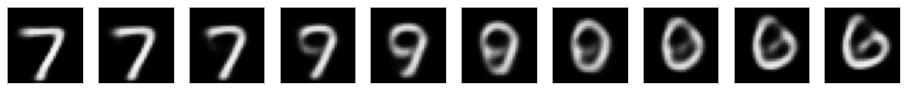

In [ ]:
interp_steps = 10
weight = torch.linspace(0, 1, steps=interp_steps)
interp = torch.lerp(
    latent_space1_mu.repeat(interp_steps, 1),
    latent_space2_mu.repeat(interp_steps, 1),
    weight=weight.view(-1, 1).cuda(),
)
iterp_images = decoder(interp)
_, axs = plt.subplots(nrows=1, ncols=interp_steps, figsize=(16, 4))
for label in range(0, interp_steps):
    figure = iterp_images[label].cpu().detach().numpy()
    figure = figure.reshape(28, 28)
    ax = axs[label]
    ax.imshow(figure, cmap="Greys_r", clim=(0, 1))
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Векторная арифметика

В принципе, можно даже в латентном пространстве брать разницу черт написания двух одинаковых цифр, прибавлять к другой цифре, получая в результате цифру, написанную немного по-другому.

Подробнее:

У нас есть 1, написанная без наклона и 1, написанная с наклоном.
И у нас есть 9 без наклона.

Вычитаем из латентного кода 1 с наклоном латентный код единицы без наклона и прибавляем к 9. Если все пройдет хорошо — получим девятку с наклоном.


<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/vector_arithmetics_1.png" alt="Drawing" width= "700px;"/>




Такое можно делать и для других примеров — добавлять людям на изображении очки, например. В дальнейшем мы будем разбирать модели, умеющие получать эмбеддинги текстов, и затронем тему векторной арифметики для слов.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/vector_arithmetics_2.png" alt="Drawing" width= "700px;"/>




In [ ]:
from PIL import Image

images, labels = next(iter(test_loader))
real9_f = images[labels == 9][0:1]
real9_s = images[labels == 9][1:2]
real1 = images[labels == 1][0:1]

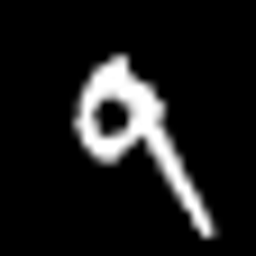

In [ ]:
size = (256, 256)
Image.fromarray(np.uint8(np.squeeze(real9_f.numpy()) * 255)).resize(size)

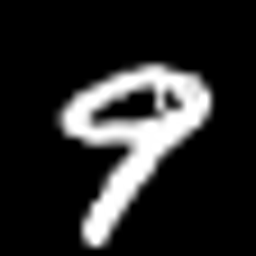

In [ ]:
Image.fromarray(np.uint8(np.squeeze(real9_s.numpy()) * 255) ).resize(size)

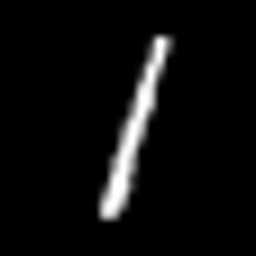

In [ ]:
Image.fromarray(np.uint8(np.squeeze(real1.numpy()) * 255) ).resize(size)

In [ ]:
latent_9f, _ = vae_split(encoder(real9_f.cuda()))
latent_9s, _ = vae_split(encoder(real9_s.cuda()))
latent_1, _ = vae_split(encoder(real1.cuda()))

In [ ]:
latent = latent_1 + latent_9f - latent_9s
gen = decoder(latent)

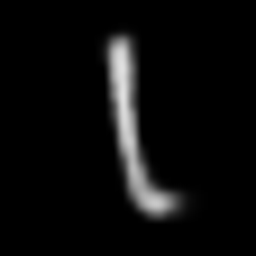

In [ ]:
Image.fromarray(np.uint8(np.squeeze(gen.cpu().detach().numpy()) * 255) ).resize(size)

Получилось перенести на 1 часть стиля 9 на каком-то минимальном уровне. Обычно для получения возможности использовать векторную арифметику, используют специальные лоссы и архитектуры. Простой VAE не гарантирует того, что "фокус удастся"..

### Примеры
Source: https://doi.org/10.1038/s41467-021-21879-w

В этой работе сначала выучили внутренние особенности TCR при помощи VAE, а потом блок энкодера использовали для задач предсказания аффинности.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/example_tcr_vae.png" alt="Drawing" width= "800px;"/>

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/example_tcr.png" alt="Drawing" width= "800px;"/>


Source: https://www.biorxiv.org/content/10.1101/2020.12.21.423785v1

Предсказывали патогенность миссенс-мутаций в геноме человека. Но делали это очень красивым непрямым способом.

Сначала для каждого белок-кодирующего гена брали выравнивание гомологов из всех возможных геномов (> 139 тыс. организмов). Вариационный автоэнкодер обучали сжимать такие выравнивания. В процессе этого автоэнкодер выучивал распределения, по которым для каждой возможной мутации в каждой позиции можно было оценить, насколько она вероятна. Выражением этой вероятности считался некоторый “эволюционный индекс”.





В ходе собственно классификации эволюционные индексы всех возможных мутаций (каждого белка по отдельности?) собрали в одно распределение. Оно оказалось двугорбым, и его разделили на две гауссианы, условно соответствующие патогенным и не патогенным мутациям. Исходя из этих двух гауссиан, каждой отдельной мутации присвоили метку -- вероятность этой мутации оказаться или не оказаться патогенной.

<img src="https://www.biorxiv.org/content/biorxiv/early/2020/12/22/2020.12.21.423785/F1.large.jpg" alt="Drawing" width= "800px;"/>

Полученные скоры хорошо предсказывают метки из базы ClinVar (AUC 0.90) и дают уверенные предсказания для многих мутаций, эффект которых не известен. А так как модель при обучении не видит сами метки --  у нее нет возможности переобучиться.


# Проблемы  «ванильного» VAE

Одна из проблем VAE, с которой можно столкнуться, состоит в том, что две компоненты лосса конфликтуют друг с другом. Если будет доминировать KL-loss, то мы получим представление, из которого наши объекты очень плохо восстанавливаются — они раскиданы по представлению, как угодно.

Если же наоборот, будем доминировать reconstruction loss, то мы получим ситуацию, в которой объекты восстанавливаются нормально, но никакой непрерывностью и не пахло.

Проблема возникает и с самой KL-дивергенцией, у которой есть ряд существенных недостатков. Есть другие способы оценки близости двух распределений, которые порой дают лучшие результаты. К ним относится дивергенция Йенсена — Шеннона, и метрика Васерштейна (используется в Wasserstein autoencoders), изучение которых выходит за рамки курса.

Кроме того, в случае, когда декодировщик содержит значительно больше параметров, нежели кодировщик, может возникать ситуация, при которой сгенерированное латентное представление игнорируется.



## Автоэнкодеры с условием(cAE)

Как, используя обычный VAE, сгенерировать картинку с заданной меткой?

На самом деле, задача нетривиальна. Как вариант, мы можем понять, в какую область латентного пространства VAE отображает все 0 и затем сэмплировать уже из этой области.

На самом деле, есть еще одна проблема. Что, если распределение объектов действительно сильно зависит от какой-то дополнительной информации, например, того, какую цифру хотел изобразить человек? Тогда KL-loss будет пытаться «скрестить ежа с ужом» и в результате мы получим очень странное представление и опять же, на границах всё ещё могут получаться несуществующие в реальности мутанты.

Продемонстрировать мы это можем на модельной задаче. Сгенерируем два несвязных набора точек в двумерном пространстве, каждый из которых представляет собой некий паттерн с добавленным шумом.



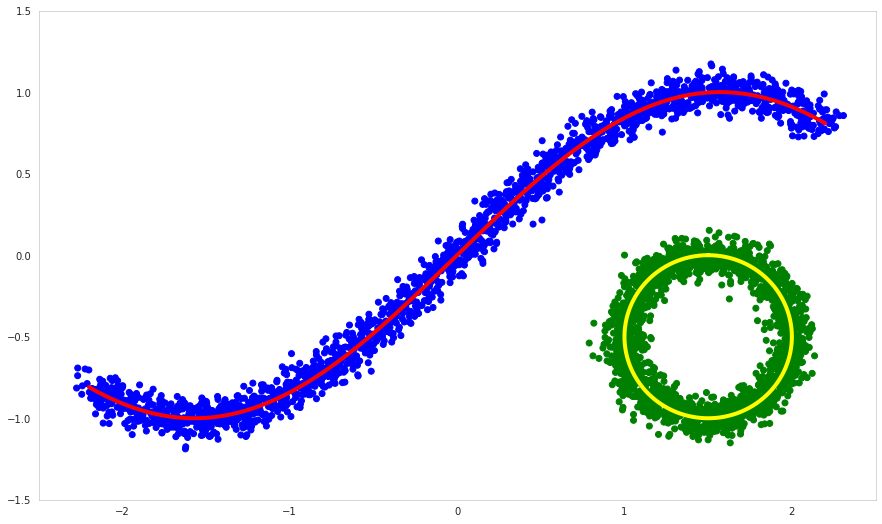

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Создание датасета
x1 = np.linspace(-2.2, 2.2, 2000)
fx = np.sin(x1)
dots1 = np.vstack([x1, fx]).T

t = np.linspace(0, 2 * np.pi, num=2000)
dots2 = 0.5 * np.array([np.sin(t), np.cos(t)]).T + np.array([1.5, -0.5])[None, :]

dots = np.vstack([dots1, dots2])
noise = 0.06 * np.random.randn(*dots.shape)

labels = np.array([0] * x1.shape[0] + [1] * t.shape[0])
noised = dots + noise


# Визуализация
colors = ["b"] * x1.shape[0] + ["g"] * t.shape[0]
plt.figure(figsize=(15, 9))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.plot(dots1[:, 0], dots1[:, 1], color="red", linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1], color="yellow", linewidth=4)
plt.grid(False)
plt.show()

Теперь попробуем обучить обычный автоэнкодер и посмотрим, что он выучил. Мы увидим, что он показывает связь там, где она явно отсутствует. Требование получить одно и то же представление для точек из двух паттернов мешают автоэнкодеру нормально выучить эти паттерны — они получаются смазанными или даже неверными.

In [ ]:
class SimpleEncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(64, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
#В прошлых примерах мы этим пренебрегали, но строго говоря автоэнкодер тоже может переобучаться.
#Потому сделаем разбиение на обучение и тест

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(noised, test_size=0.25, random_state=777)
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

In [ ]:
#Чтобы сильно не мучаться, поставим просто scheduler, который автоматически уменьшает learning rate нашей сети,
#если она переобучается или просто не улучшает качество на валидационном датасете

encdec = SimpleEncoderDecoder()
optimizer = optim.Adam(encdec.parameters())
loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=50)


for i in range(5000):
    optimizer.zero_grad()
    X_restored = encdec(X_train)
    loss = loss_fn(X_train, X_restored)
    loss.backward()
    if optimizer.param_groups[0]["lr"] < 10e-7:
        print(i)
        break

    with torch.no_grad():
        X_restored = encdec(X_test)
        val_loss = loss_fn(X_test, X_restored)
    scheduler.step(val_loss)
    optimizer.step()

print(val_loss.item())

2249
0.030498847365379333


In [ ]:
with torch.no_grad():
    X_restored = encdec(X_test)
    dots_restored = X_restored.numpy()

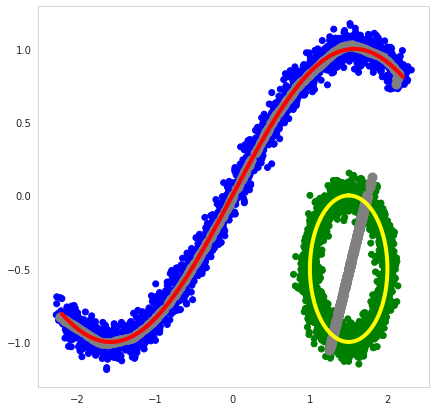

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(dots1[:, 0], dots1[:, 1], color="red", linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1], color="yellow", linewidth=4)
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.scatter(dots_restored[:, 0], dots_restored[:, 1], color="grey", linewidth=4)
plt.grid(False)
plt.show()

Видим, что наш автоэнкодер восстанавливает часть объектов в область, где ничего нет. Потому что у него нет воможности понять, что это две несвязные компоненты.

А что будет, если мы будем передавать в кодировщик и в декодировщик метку объекта?

In [ ]:
class SimpleConditionalEncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(64, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(32, 2),
        )

    def forward(self, x, y):
        x = torch.cat([x, y.view(-1, 1)], dim=1)
        z = self.encoder(x)
        x = torch.cat([z, y.view(-1, 1)], dim=1)
        x = self.decoder(x)
        return x

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    noised, labels, test_size=0.25, random_state=777
)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
encdec = SimpleConditionalEncoderDecoder()
optimizer = optim.Adam(encdec.parameters())
loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=50)


for i in range(5000):
    optimizer.zero_grad()
    X_restored = encdec(X_train, y_train)
    loss = loss_fn(X_train, X_restored)
    loss.backward()
    if optimizer.param_groups[0]["lr"] < 10e-7:
        print(i)
        break

    with torch.no_grad():
        X_restored = encdec(X_test, y_test)
        val_loss = loss_fn(X_test, X_restored)
    scheduler.step(val_loss)
    optimizer.step()
print(val_loss.item())

0.0048182955943048


In [ ]:
with torch.no_grad():
    X_restored = encdec(X_test, y_test)
    dots_restored = X_restored.numpy()

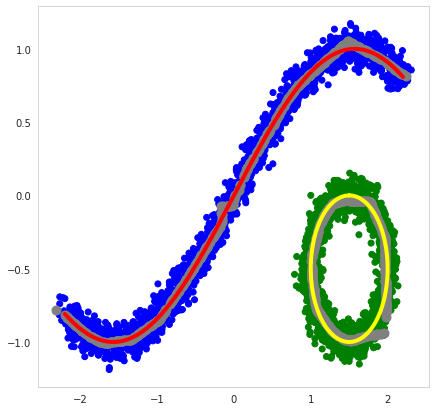

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(dots1[:, 0], dots1[:, 1], color="red", linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1], color="yellow", linewidth=4)
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.scatter(dots_restored[:, 0], dots_restored[:, 1], color="grey", linewidth=4)
plt.grid(False)
plt.show()

Ситуация стала лучше. То, что мы применили, называется условными автоэнкодерами (Conditional AE, cAE). Конкретно - вместе с признаковым описанием объекта мы также передаем метки, которые указывают на то, что он относится к каким-то важным группам объектов, для которых, возможно, сети нужно учить отличное от других представление.

## Вариационные автоэнкодеры с условиями, cVAE

Обычные автокодировщики с условиями применяются редко — они по-прежнему не гарантируют нам связность представления в пределах одной метки.

Однако, добавление меток в вариационный автокодировщик часто помогает решать уже описанные задачи на хорошем уровне.

Как подмешивать метку к изображению, чтобы передать это полностью конволюционной нейронной сети - не совсем очевидно. На самом деле, обычно это и не нужно. Часто достаточно передавать метку только декодеру. Энкодер имеет в распоряжении изначальный объект и при желании может предсказать его метку сам.

Таким образом, сеть не будет тратить силы и веса на заучивание различий между классами, а для каждого класса будет учить многообразие вариантов объектов этого класса (в нашем случае -- стили начертания).


<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/cvae.png" alt="Drawing" width= "700px;"/>




Напишем код для CVAE. По сути надо поменять только декодер

In [ ]:
class CDecoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32]
        self.linear = nn.Linear(
            in_features=latent_size + 10, out_features=hidden_dims[0]
        )

        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    hidden_dims[-1],
                    hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x, lab):
        x = torch.cat([x, lab], dim=1)
        x = self.linear(x)
        x = x.view(-1, 512, 1, 1)
        x = self.decoder(x)
        return x

In [ ]:
def cvae_pass_handler(encoder, decoder, data, lab, *args, **kwargs):
    latent = encoder(data)
    mu, log_var = vae_split(latent)
    sample = vae_reparametrize(mu, log_var)
    lab = torch.nn.functional.one_hot(lab, num_classes=10)
    recons = decoder(sample, lab)
    return latent, recons

In [ ]:
latent_size = 2

learning_rate = 1e-2
encoder = VAEEncoder(latent_size=latent_size * 2)
decoder = CDecoder(latent_size=latent_size)


encoder = encoder.cuda()
decoder = decoder.cuda()

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
from functools import partial

for i in range(1, 6):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=cvae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=450,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.646231
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.207884
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.194312
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.194409
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.193418
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.186456
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.186981
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.201789
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.194394
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.182532
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.178604
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.179049
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.174544
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.197152
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.196636


In [ ]:
encoder = encoder.eval()
decoder = decoder.eval()

run_res = run_eval(encoder, decoder, test_loader, cvae_pass_handler)

Добавив передачу метки в декодер, мы позволили автоенкодеру отображать все цифры в одну и ту же область. За счет этого ему легче стало учиться, лосс стал чуть ниже.

При этом если нарисовать латентное представление для всех наших цифр разом, получится комок, сосредоточенный в области нормального распределения. Это не значит, что оно плохое. Просто наша картина не учитывает, что нейросеть различает цифры теперь по меткам, а не по латентному представлению

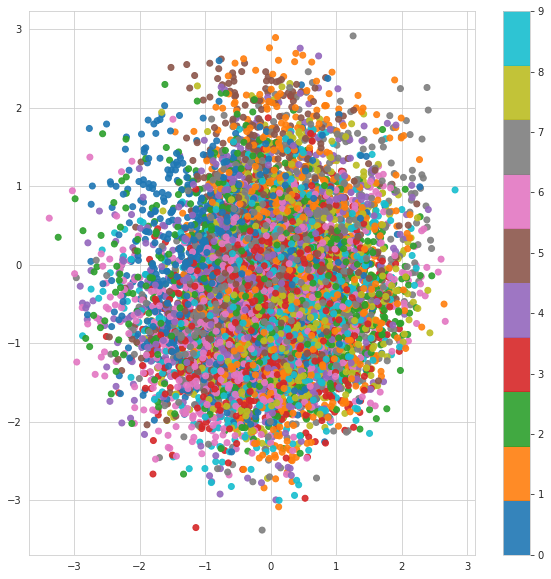

In [ ]:
plot_manifold(run_res['latent'], run_res['labels'])

Теперь у каждой цифры "свое" нормальное распределение

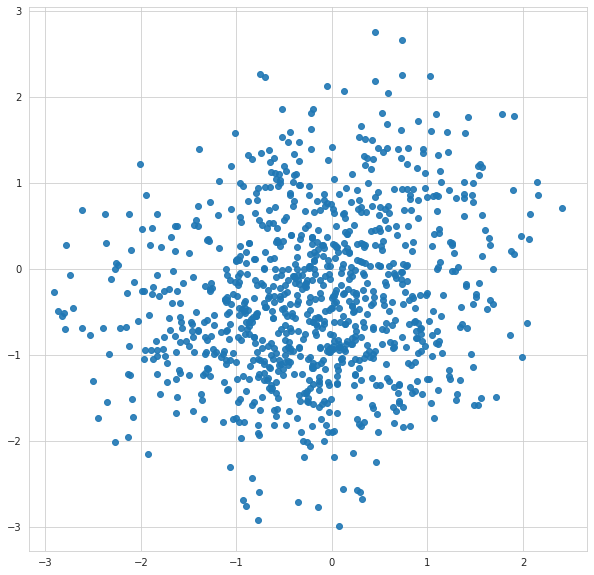

In [ ]:
plot_manifold(run_res['latent'][run_res['labels'] == 4])

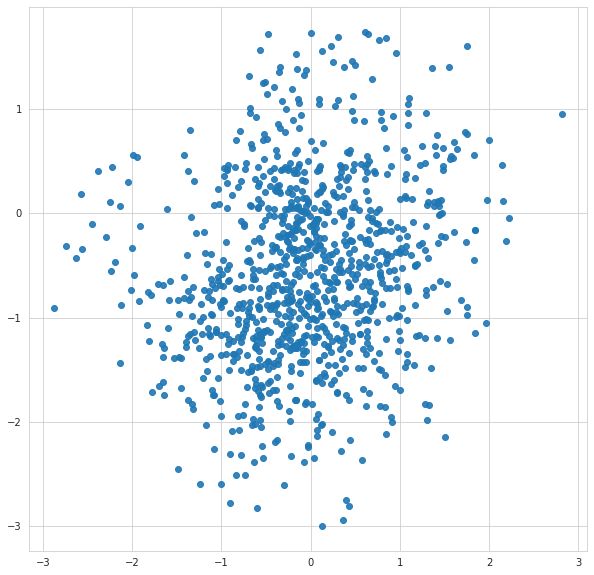

In [ ]:
plot_manifold(run_res['latent'][run_res['labels'] == 9])

### Генерация заданных цифр из латентного распределения

Посмотрим, как выглядят наше латентное представление, скажем, для четверок, которых мы до этого почти не видели (сливались с 9)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


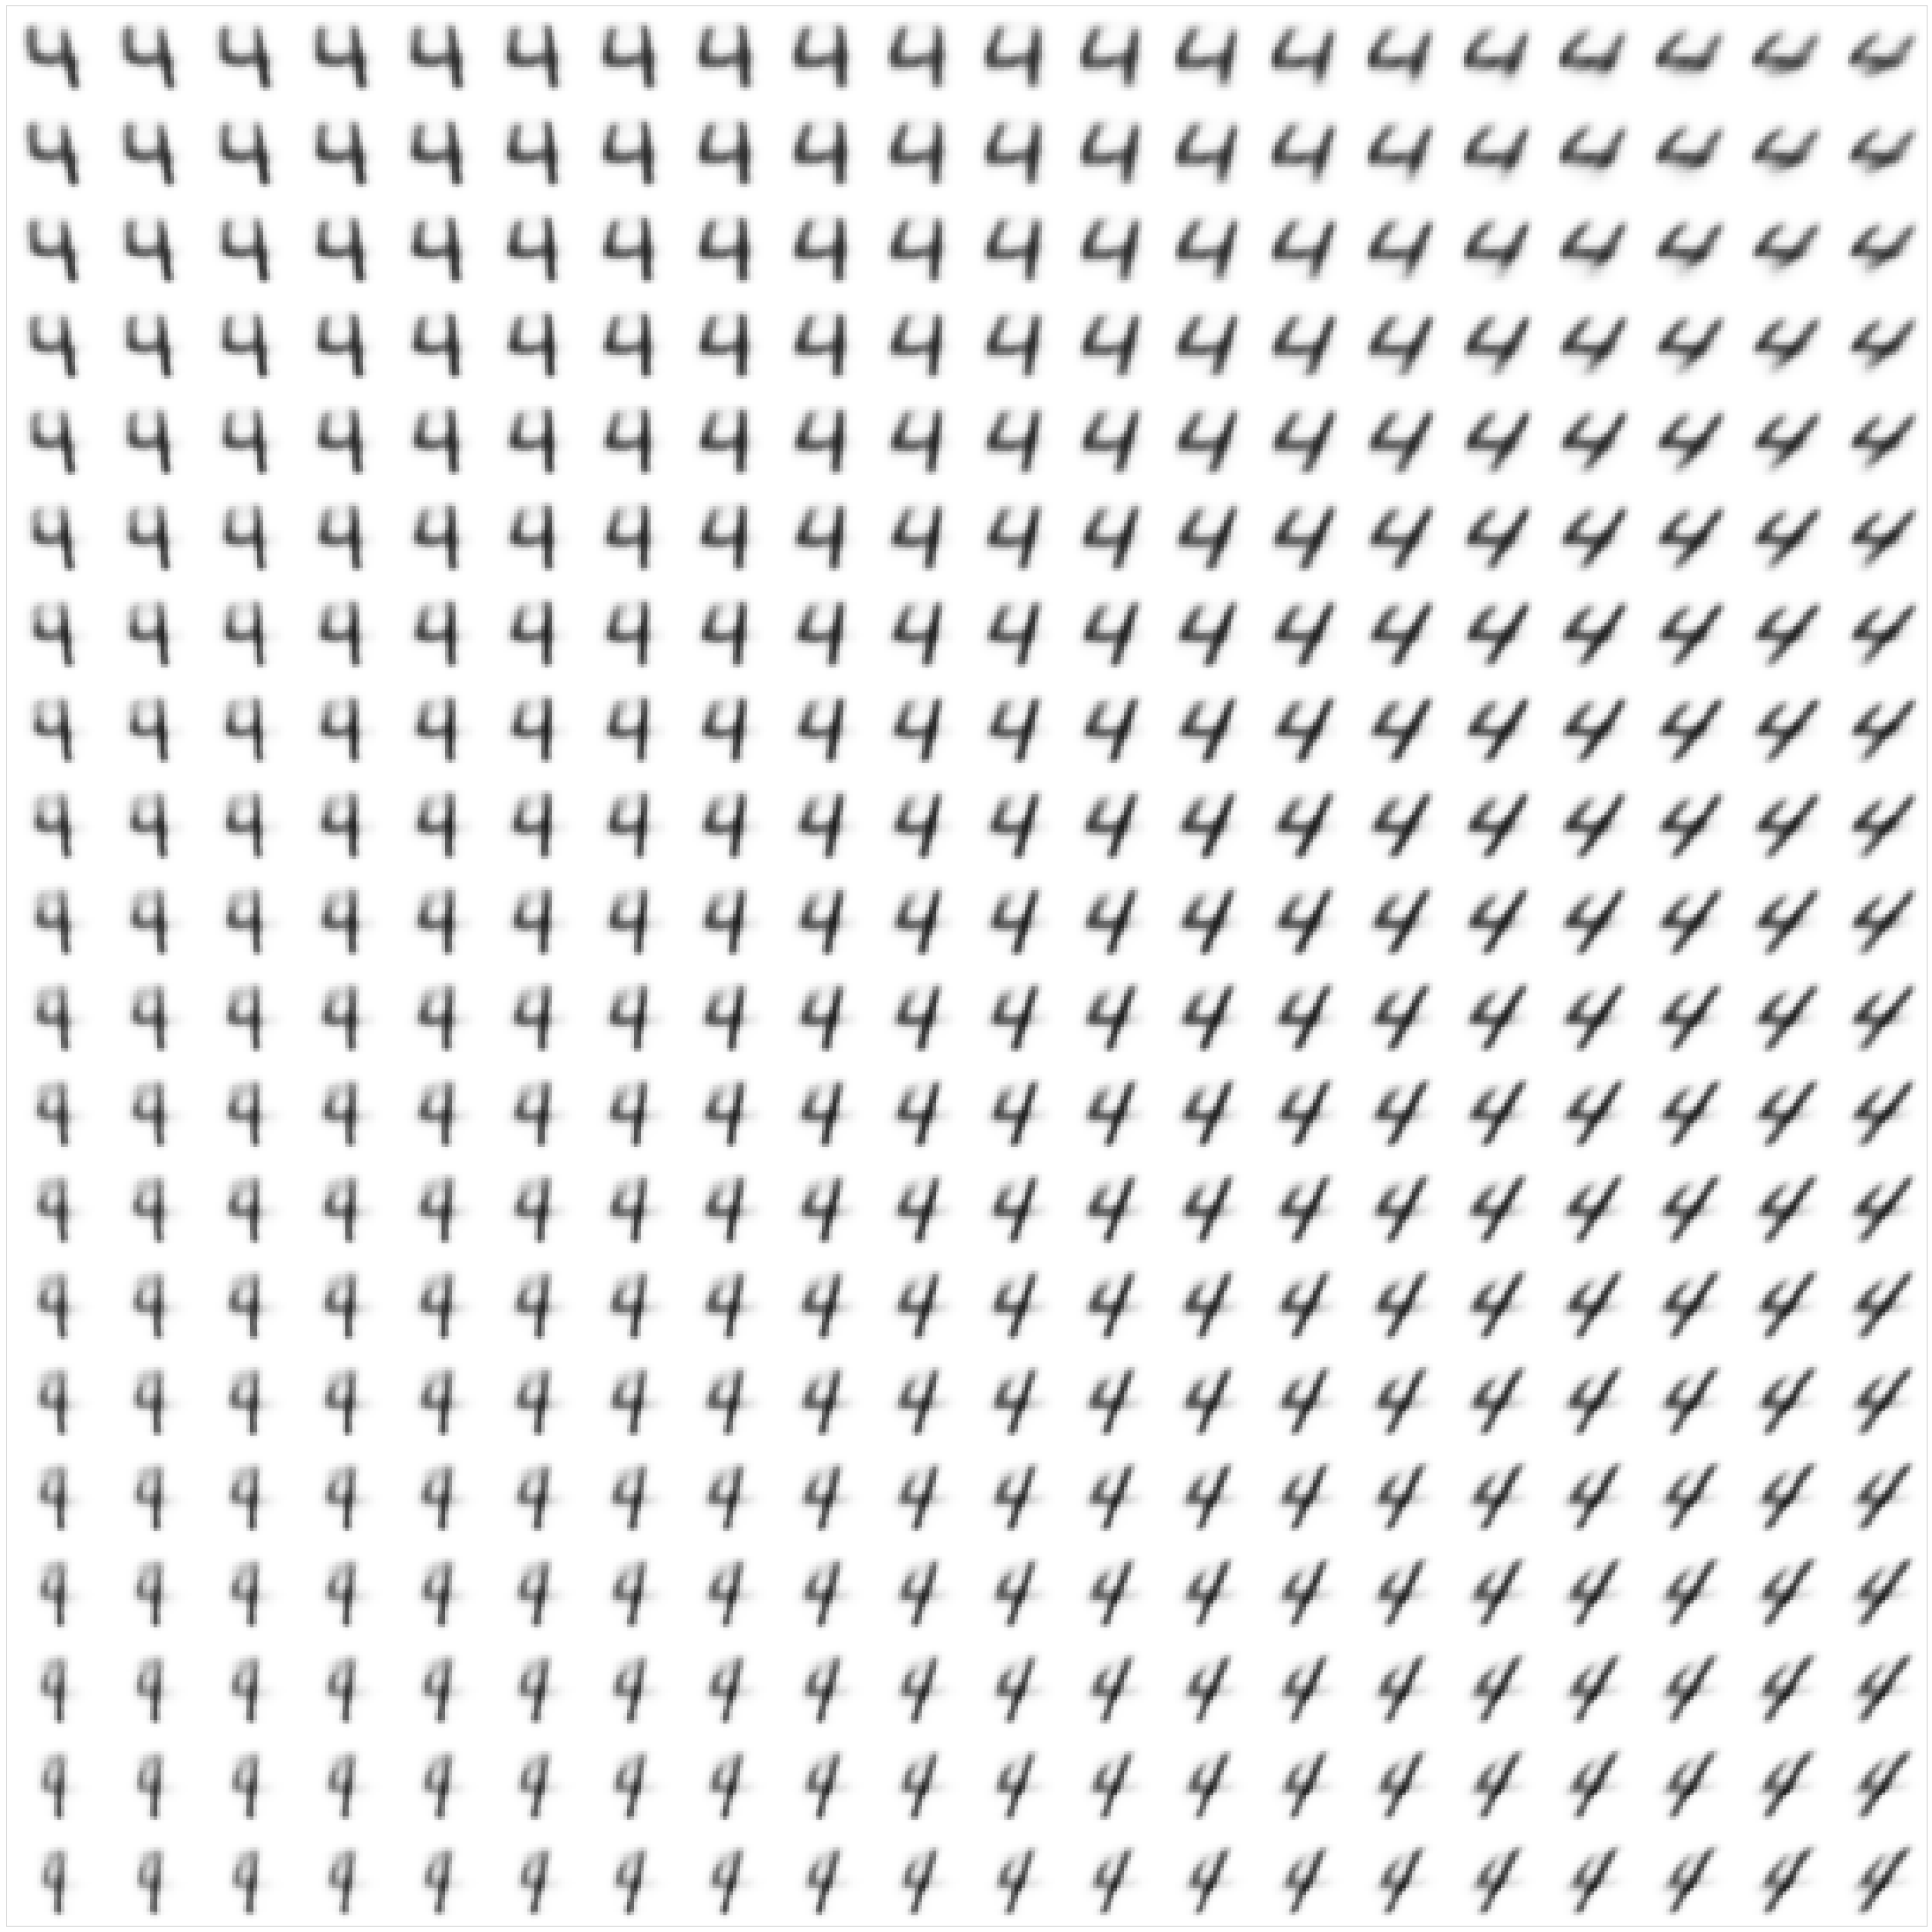

In [ ]:
steps = 20
space1 = torch.linspace(-2, 2, steps)
space2 = torch.linspace(-2, 2, steps)
grid = torch.cartesian_prod(space1, space2)
lab = torch.full((grid.shape[0],), 4)
lab = torch.nn.functional.one_hot(lab, num_classes=10)
with torch.no_grad():

    images = decoder(grid.cuda(), lab.cuda())
    images = images.cpu().numpy().squeeze()

plot_digits(*[images[x : x + steps] for x in range(0, steps * steps, steps)])

# Постановка задач в Computer Vision


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/encoders_segment/clas_vs_seg.png" alt="Drawing" width= "900px;"/>

Ранее, когда мы работали с изображениями, чаще всего речь шла о классификации: для изображения модель предсказывает вектор с вероятностями классов. При этом без дополнительного исследования Model Explainability (SHAP, LIME) мы чаще всего не имеем ни малейшего представления о том, на основании каких именно признаков модель принимает то или иное решение.

Можно поставить задачу немного по-другому: требовать от модели напрямую показывать нам, где именно на изображении находятся области, на основании которых она приняла решение о причислении изображения к тому или иному классу, или обозначить все области, на которых находится объект того или иного класса (задача детектирования). По сути мы хотим, чтобы модель предсказывала нам границы полигона (чаще всего -- прямоугольника) для каждого найденного объекта. Это означает, что вместо классификации мы решаем задачу <b>регрессии</b>.



<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/task_detection.jpg" alt="Drawing" width= "700px;"/>

В случае одного объекта можно обучить модель предсказывать числа:

* координаты центра + ширину и высоту
* координаты правого верхнего и левого нижнего углов
* координаты вершин полигона

Для детектирования многих объектов разных классов используются более сложные схемы.

В контексте биологических задач нам больше интересная другая задача -- задача <b>сегментации</b> изображений. В ходе решения этой задачи модель на основе исходного изображения должна попиксельно разметить объект, то есть вывести его **маску** -- в случае задачи **семантической сегментации** отнести все пиксели изображения к тому или иному классу, а в случае обнаружения объектов-- только для значимых участков (в случае множественных классов -- правильно сопоставить каждому выделенному участку его класс).

Биологические изображения могут быть достаточно разными по характеру и свойствам: МРТ, КТ, рентген, гистологические снимки с разными окрашиваниями, иметь различное качество и артефакты.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/example_histology.png" width= "900px;"/>


С одной из таких задач -- сегментации легких на рентгеновских снимках груди -- мы сегодня столкнемся на семинаре.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/example_lungs.png" width= "900px;"/>

## Сегментация изображений

Какие подходы позволят нам наиболее эффективно решать задачу сегментации изображения?

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/task_segmentation.png" alt="Drawing" width= "900px;"/>

Формальная постановка задачи: **Предсказать класс для каждого пикселя.**

На вход модели подаем изображение, требуем предсказать маску, то есть матрицу такого же размера, в которой ненулевые значения принимают пиксели, относящиеся к области интереса (в случае нескольких классов -- по маске на класс).

Это означает, что для тренировки модели мы должны собрать датасет, в котором каждому изображению будет соотвествовать уже не метка класса, а целая маска, причем чаще всего размеченная вручную. Сбор данных в сколько-нибудь достаточном количестве превращается в отдельную задачу..

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/segmentation.png" alt="Drawing" width= "900px;"/>

### Способы решения

**а) Наивный.** Попробовать напрямую свести задачу к классификации.


Скользящим окном пройтись по изображению и предсказать клас для каждого пикселя с учетом его соседей. Логично предположить, что работать это будет ужасно долго и при этом не очень хорошо. Использовать одни и те же признаки много раз подряд -- мягко говоря, не самое эффективное решение.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/segmentation_approach_naive.png" alt="Drawing" width= "700px;"/>

**б) Разумный**. Обрабатывать всё изображение одновременно.

Убрать линейный слой в конце сети. Пропустив изображение через много-много конволюций (не меняя размер самого изображения!), по признакам во всех каналах определять класс каждого пикселя. В конце свертку 1x1 можно рассматривать как полносвязанный слой -- именно так она и будет использоваться при сегментации, выдавая скор для каждого класса для каждого пикселя на изображении.

Количество классов будет соответствовать числу каналов.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/segmentation_approach_good.png" alt="Drawing" width= "700px;"/>

Подход хороший, но есть проблемы:

1) хотим посмотреть на всю картинку и агрегировать в каждый пиксель информацию о многих его соседях, соответственно нужно большое рецептивное поле, следовательно нужно очень много слоев.

2) очень медленно работает на полноразмерных картах активации

**в) Эффективный**.

Использовать подход автоэнкодера: внутри сети сначала сжать информацию, таким образом где-то в низкоразмерном представлении каждый из "новых пикселей" будет знать информацию обо всем изображении. На этом уровне мы можем получить правильное число классов, но после этого нам нужно вернуться к исходному размеру изображения.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/segmentation_approach_better.png" alt="Drawing" width= "700px;"/>

Но как "разворачивать" изображение?

Есть различные способы повышения размеров изображений.

Cпособ, который мы знаем: входное разрешение дополняется нулями (подобно паддингу) до такого разрешения, чтобы выходное разрешение было больше входного. За один шаг таким образом увеличить изображение не получится, поэтому слоёв ставится несколько, чтобы каждый новый слой лучше восстанавливал то, что в него подают. Итеративно увеличивая разрешения, ядра свёрток учатся генерировать изображения более высокой размерности.

Из изображения 2х2 в изображение 4х4:

![alttext](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/conv_transpose_anim_2x2-4x4.gif)

Из изображения 3х3 в изображение 5х5 с использованием паддинга и dilation:

![alttext](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/conv_transpose_anim_3x3-5x5-pad-dil.gif)





![trans_conv](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/conv_transpose_anim_3x3-5x5-pad-dil.gif)

Реализовано это в блоке ConvTranspose2d.

https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html


In [ ]:
import torch
from torch import nn
# exact output size can be also specified as an argument
input = torch.randn(1, 16, 12, 12)
downsample = nn.Conv2d(16, 16, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
print("Original: ", input.size())
h = downsample(input)
print("Downsampled: ",h.size())
output = upsample(h, output_size=input.size())
print("Upsampled: ",output.size())

Original:  torch.Size([1, 16, 12, 12])
Downsampled:  torch.Size([1, 16, 6, 6])
Upsampled:  torch.Size([1, 16, 12, 12])


Недостаток такого подхода - он приводит к так называемому checkboard паттерну (подробнее - [здесь](https://distill.pub/2016/deconv-checkerboard/)).

Сейчас используется метод resize-convolution.

В нем вначале делают [билинейную интерполяцию](https://theailearner.com/2018/12/29/image-processing-bilinear-interpolation/) (см. дополнительные материалы в конце лекции), которая повышает разрешение feature map, а затем применяют обычную конволюцию с `padding="same"`, которая убирает артефакты, вносимые такой интерполяцией.

##  U-Net

Пополярная архитектура, изначально созданная для сегментации медицинских изображений. В данном случае структура декодера повторяет структуру энкодера, но имеет значимое отличие: используется подход, схожий с идеей DenseNet.
Признаки декодера объединяются с соответствующими им по размерам признаками из энкодера на входе каждого блока. Это позволяет одновременно обрабатывать информацию и о локальной, и о глобальной структуре изображения.

![alttext](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/ae_unet.png)

https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

Для борьбы с переобучением на уровне "глобальных" признаков мы работаем с большим количеством фичей (много feature maps), а на уровне "локальных" стараемся держать этот параметр низким.

Эта архитектура достаточно популярна и до сих пор. Например, на  Kaggle в соревновании, посвященном сегментации опухолей на снимках мозга, в топе в основном именно модели, построенные по U-Net-архитектуре.

https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/example_unet_mri_segmentation.png" alt="Drawing" width= "700px;"/>

## Loss

Какую же лосс-функцию использовать для задач сегментации?


Стандартное решение (несмотря на кажущуюся простоту) -- просто попиксельно считать кросс-энтропию между маской (из 0 и 1) и предсказанием. И это рабочий вариант!

https://www.jeremyjordan.me/semantic-segmentation/


<img src="https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-24-at-10.46.16-PM.png" alt="Drawing" width= "700px;"/>

Чтобы оценивать качество готовой разметки в задаче сегментации, можно использовать **индекс Жаккара** (он же IoU, intersection over union) и **коэффициент Дайса**.

* Индекс Жаккара или IoU считается как отношение пересечения предсказания и маски к их объединению.

$$Jaccard Index = \frac{TP}{TP+FP+FN} = \frac{|X∩Y|}{|X∪Y|}$$


* [Коэффициент Сёренсена-Дайса](
https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) -- статистика, используемая для оценки сходства двух выборок.

$$Dice\_coeff = \frac{2∗|X∩Y|}{|X|+|Y|}$$

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/jaccard_and_dice_qm.png" alt="Drawing" width= "900px;"/>




 ## Интересные ссылки


1. [Age Progression/Regression - преедсказание того, как будет выглядеть человек в другом возрасте](https://arxiv.org/abs/1702.08423)


2. [Генерация лекарств, специфически меняющих активность генов человека](https://www.frontiersin.org/articles/10.3389/fphar.2020.00269/full)


3. [Получение латентных представлений транскриптомов](https://academic.oup.com/nar/article/48/10/e56/5814052)

4. [MethylNet](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-3443-8) - Использование метилирования генома для обучения латентного представления, помогающего в предсказании возраста и т.д

5. [scVAE](https://academic.oup.com/bioinformatics/article-abstract/36/16/4415/5838187?redirectedFrom=fulltext) - получение данных об экспрессии генов из single cell данных

6. [U-Net](https://arxiv.org/abs/1505.04597) - сегментация медицинских изображений

7. [W-Net](https://arxiv.org/abs/1711.08506) - unsupervised сегментация медицинских изображений

## *Дополнительно: интерполяция для повышения размеров изображений

Можно использовать **Интерполяцию** и сопоставлять новым пикселям значения на основании их окружения (маловероятно, что посередине поля зеленых пикселей будет один одинокой красный) -- по ближайшему соседу, линейно, билинейно, бикубически...

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/interpolation.png" alt="Drawing" width= "700px;"/>

https://en.wikipedia.org/wiki/Bilinear_interpolation

В PyTorch это реализовано в специальном блоке Upsample

https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/pytorch-upsample.png" alt="Drawing" width= "700px;"/>


Подобная операция есть и для пуллинга, при этом при сжатии изображения запоминаются индексы максимальных элементов:
https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html